In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))
import ast

# Any results you write to the current directory are saved as output.

import json
import ast
from collections import Counter
import time
import datetime
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df_train = pd.read_csv('tmdb-box-office-prediction/train.csv')
df_test = pd.read_csv('tmdb-box-office-prediction/test.csv')
submission = pd.read_csv('tmdb-box-office-prediction/sample_submission.csv')

In [3]:
# from this kernel: https://www.kaggle.com/gravix/gradient-in-a-box
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

In [4]:
def text_to_dict(df, columns_to_parse):
    for column in columns_to_parse:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

In [5]:
df_train_clean = text_to_dict(df_train,dict_columns)
df_test_clean = text_to_dict(df_test, dict_columns)

In [6]:
df_train_clean.info()
df_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    3000 non-null object
budget                   3000 non-null int64
genres                   3000 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     3000 non-null object
production_countries     3000 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         3000 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords            

# Create new feature

In [7]:
columns_to_select = ['genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

In [8]:
df_train_clean['has_collection'] = df_train_clean['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)
df_test_clean['has_collection'] = df_test_clean['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

In [9]:
def number_of_values(df, columns):
    for column in columns:
        new_column_name = 'num_' + column
        df[new_column_name] = df[column].apply(lambda x: len(x) if x != {} else 0)
    return df

In [10]:
df_train_clean = number_of_values(df_train_clean, columns_to_select)
df_test_clean = number_of_values(df_test_clean, columns_to_select)

In [11]:
def list_of_values(df, columns, key):
    for column in columns:
        new_column_name = 'all_' + column + '_' + key
        df[new_column_name] = df[column].apply(lambda x: ' '.join(sorted([i[key] for i in x])) if x != {} else '')
    return df

In [12]:
columns_to_select = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

In [13]:
df_train_clean = list_of_values(df_train_clean, columns_to_select, 'name')
df_test_clean = list_of_values(df_test_clean, columns_to_select, 'name')

In [14]:
columns_top_to_select = {'belongs_to_collection':32, 'genres': 10, 'production_companies': 20,
                'production_countries': 15, 'spoken_languages': 15, 'Keywords':30, 'cast':30, 'crew':20}

In [15]:
def top_values(df_calculate_top, df_apply_top, columns_to_select, key):
    for column, top_value in columns_to_select.items():
        list_of_values = df_calculate_top[column].apply(lambda x: [i[key] for i in x] if x != {} else []).values
        top_values = [m[0] for m in Counter([i for j in list_of_values for i in j]).most_common(top_value)]
        for value in top_values:
            df_apply_top[column+'_'+key+'_'+value] = df_apply_top['all_'+column+'_'+key].apply(lambda x: 1 if value in x else 0)
    return df_apply_top

In [16]:
df_train_clean = top_values(df_train_clean, df_train_clean, columns_top_to_select, 'name')
df_test_clean = top_values(df_train_clean, df_test_clean, columns_top_to_select, 'name')

In [17]:
#df_train_clean.head()

# Create new feature for main character

In [18]:
df_train_clean = list_of_values(df_train_clean, ['cast'], 'character')
df_test_clean = list_of_values(df_test_clean, ['cast'], 'character')

columns_top_to_select = {'cast': 10}
df_train_clean = top_values(df_train_clean, df_train_clean, columns_top_to_select, 'character')
df_test_clean = top_values(df_train_clean, df_test_clean, columns_top_to_select, 'character')

In [19]:
#count gender
dict_gender = {0:'genunk', 1:'female', 2:'male'}

In [20]:
def count_gender(df, dict_gender, column, key):
    for k, v in dict_gender.items():
        df['num' + '_' + column + '_' + key + '_' + v] = df[column].apply(lambda x: sum([1 for i in x if i[key] == k]))
    return df

In [21]:
#cast gender
df_train_clean = count_gender(df_train_clean, dict_gender, 'cast', 'gender')
df_test_clean = count_gender(df_test_clean, dict_gender, 'cast', 'gender')

In [22]:
#crew gender
df_train_clean = count_gender(df_train_clean, dict_gender, 'crew', 'gender')
df_test_clean = count_gender(df_test_clean, dict_gender, 'crew', 'gender')

In [23]:
def top_jobs(df, all_values, column, new_column_name, top):
    top = [m[0] for m in Counter([i for j in all_values for i in j]).most_common(top)]
    for value in top:
        df[new_column_name+'_'+value] = df[column].apply(lambda x: 1 if value in str(x) else 0)
    return df

In [24]:
#df_train_clean.head()

# main director

In [25]:
list_directors = list(df_train_clean['crew'].apply(lambda x: [i['name'] for i in x if i['job'] == 'Director'] if x != {} else []).values)
df_train_clean = top_jobs(df_train_clean, list_directors, 'crew', 'director', 30)
df_test_clean = top_jobs(df_test_clean, list_directors, 'crew', 'director', 30)

# main producers

In [26]:
list_producers = list(df_train_clean['crew'].apply(lambda x: [i['name'] for i in x if i['job'] == 'Executive Producer'] if x != {} else []).values)
df_train_clean = top_jobs(df_train_clean, list_producers, 'crew', 'producer', 15)
df_test_clean = top_jobs(df_test_clean, list_producers, 'crew', 'producer', 15)

In [27]:
def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year


In [28]:
df_test_clean.loc[df_test_clean['release_date'].isnull() == True, 'release_date'] = '01/01/98' 


In [29]:
df_train_clean['release_date'] = df_train_clean['release_date'].apply(lambda x: fix_date(x))
df_test_clean['release_date'] = df_test_clean['release_date'].apply(lambda x: fix_date(x))
df_train_clean['release_date'] = pd.to_datetime(df_train_clean['release_date'])
df_test_clean['release_date'] = pd.to_datetime(df_test_clean['release_date'])

In [30]:
df_train_clean['year']=pd.DatetimeIndex(df_train_clean['release_date']).year
df_test_clean['year']=pd.DatetimeIndex(df_test_clean['release_date']).year
df_train_clean['month']=pd.DatetimeIndex(df_train_clean['release_date']).month
df_test_clean['month']=pd.DatetimeIndex(df_test_clean['release_date']).month
df_train_clean['yr_mth']=df_train_clean['year']*100+df_train_clean['month']
df_test_clean['yr_mth']=df_test_clean['year']*100+df_test_clean['month']

# Remove unnacessary Feature

In [31]:
def find_features_start_by(df, start):
    features = list(df)
    start_by = []
    for feature in features:
        if feature.startswith(start):
            start_by.append(feature)
    return start_by

In [32]:
#drop from train set
features_to_drop = find_features_start_by(df_train_clean, 'all_')
df_train_clean = df_train_clean.drop(features_to_drop, axis=1)

#drop from test set
df_test_clean = df_test_clean.drop(features_to_drop, axis=1)

In [33]:
original_features = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries',
                     'spoken_languages', 'Keywords', 'cast', 'crew']

In [34]:
df_train_clean = df_train_clean.drop(original_features, axis=1)
df_test_clean = df_test_clean.drop(original_features, axis=1)

In [35]:
print('training set: ' + str(len(list(df_train_clean))) + ' features')
print('testing set: ' + str(len(list(df_test_clean))) + ' features')

training set: 259 features
testing set: 258 features


# Check columns in df_train_clean

In [36]:
i = 1
for column in list(df_train_clean.columns):
    print(str(i) + ' ' + column)
    i = i + 1

1 id
2 budget
3 homepage
4 imdb_id
5 original_language
6 original_title
7 overview
8 popularity
9 poster_path
10 release_date
11 runtime
12 status
13 tagline
14 title
15 revenue
16 has_collection
17 num_genres
18 num_production_companies
19 num_production_countries
20 num_spoken_languages
21 num_Keywords
22 num_cast
23 num_crew
24 belongs_to_collection_name_James Bond Collection
25 belongs_to_collection_name_Friday the 13th Collection
26 belongs_to_collection_name_The Pink Panther (Original) Collection
27 belongs_to_collection_name_Police Academy Collection
28 belongs_to_collection_name_Pokémon Collection
29 belongs_to_collection_name_Rocky Collection
30 belongs_to_collection_name_Ice Age Collection
31 belongs_to_collection_name_The Fast and the Furious Collection
32 belongs_to_collection_name_Rambo Collection
33 belongs_to_collection_name_Alien Collection
34 belongs_to_collection_name_Resident Evil Collection
35 belongs_to_collection_name_Child's Play Collection
36 belongs_to_collecti

In [37]:
original_language_numbering={
    "en":1,"fr":2,"ru":3, "es":4, "hi":5, "ja":6,"it":7, "ko":8, "cn":9,"zh":10, 
    "de":11, "ta":12, "sv":13, "nl":14, "pt":15, "da":16, "fa":17, "ro":18, "hu":19, "tr":20,
    "ml":21, "no":22, "pl":23, "fi":24, "te":25, "id":26, "he":27, "ur":28, "mr":29, "cs":30,
    "sr":31, "ar":32, "nb":33, "el":34, "bn":35, "vi":36
}

In [38]:
df_train_clean['original_language']=df_train_clean['original_language'].map(original_language_numbering)
df_test_clean['original_language']=df_test_clean['original_language'].map(original_language_numbering)

In [39]:
print(df_test_clean['original_language'].isna().sum())
print(df_train_clean['original_language'].isna().sum())
df_test_clean['original_language'].fillna(1, inplace=True)

14
0


In [40]:
print(df_test_clean['original_language'].isna().sum())


0


# overview의 코사인 유사도로 budget 예측
## 1) df_train_clean['exp_budget']

In [41]:
df_train_clean['overview']=df_train_clean['overview'].fillna("")

In [42]:
tfidf=TfidfVectorizer(stop_words="english")
tfidf_matrix=tfidf.fit_transform(df_train_clean['overview'])
cosine_sim=linear_kernel(tfidf_matrix,tfidf_matrix) #코사인 유사도를 계산함.

In [43]:
idx=pd.Series(df_train_clean.index,index=df_train_clean['id'])

In [44]:
#my_sim : 다른 영화들과의 유사도가 저장되어 있는 벡터
def get_movies(movie_id, data=df_train_clean, my_sim=cosine_sim):
    #title 과 가장 비슷한 영화 10편 출력
    id=idx[data.iloc[movie_id]['id']]
    #title과 다른 모든 영화들간의 유사도를 계산
    sim_score=list(enumerate(my_sim[id]))
    
    #유사도에 따른 정렬
    sim_score=sorted(sim_score, key=lambda x:x[1], reverse=True) #유사도를 기준(key)으로 내림차순 정렬
    sim=sim_score[1:11] #자기 자신은 제외
    
    #영화 제목(index)을 저장.
    mymovie=[i[0] for i in sim]
    
    return data['budget'].iloc[mymovie]

In [45]:
budget_list=[]
for index in range(df_train_clean.shape[0]):
    if df_train_clean.loc[index]['budget']!=0:
        budget_list.append(df_train_clean.loc[index]['budget'])
        continue
    else :
        budget_list.append(get_movies(df_train_clean.loc[index]['id']).mean())

In [46]:
len(budget_list)
df_train_clean['exp_budget']=budget_list

In [47]:
df_train_clean.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,...,producer_Liza Chasin,producer_Tessa Ross,producer_Ben Waisbren,producer_Gary Barber,producer_Richard Brener,producer_John Lasseter,year,month,yr_mth,exp_budget
0,1,14000000,NaN,tt2637294,1,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,2015-02-20,...,0,0,0,0,0,0,2015,2,201502,14000000.0
1,2,40000000,NaN,tt0368933,1,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,2004-08-06,...,0,0,0,0,0,0,2004,8,200408,40000000.0
2,3,3300000,http://sonyclassics.com/whiplash/,tt2582802,1,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,2014-10-10,...,0,0,0,0,0,0,2014,10,201410,3300000.0
3,4,1200000,http://kahaanithefilm.com/,tt1821480,5,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,2012-03-09,...,0,0,0,0,0,0,2012,3,201203,1200000.0
4,5,0,NaN,tt1380152,8,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,2009-02-05,...,0,0,0,0,0,0,2009,2,200902,48900000.0


## 2) df_test_clean[exp_budget]

In [48]:
df_test_clean['overview']=df_test_clean['overview'].fillna("")
tfidf_test_matrix=tfidf.fit_transform(df_test_clean['overview'])
test_cosine_sim=linear_kernel(tfidf_test_matrix, tfidf_test_matrix)

test_idx=pd.Series(df_test_clean['id'])#, index=df_test_clean['id'])
#test_idx.reindex(df_test_clean['id'])

In [49]:
#my_sim : 다른 영화들과의 유사도가 저장되어 있는 벡터
def get_movies2(movie_id,data=df_test_clean, my_sim=test_cosine_sim):
    #title 과 가장 비슷한 영화 10편 출력
    id=test_idx[data.loc[movie_id-3001]['id']-3001]
    
    #title과 다른 모든 영화들간의 유사도를 계산
    sim_score=list(enumerate(my_sim[id-3001]))
  
    #유사도에 따른 정렬
    sim_score=sorted(sim_score, key=lambda x:x[1], reverse=True) #유사도를 기준(key)으로 내림차순 정렬
    sim=sim_score[1:11] #자기 자신은 제외
    
    #영화 제목(index)을 저장.
    mymovie=[i[0] for i in sim]
    
    return data['budget'].iloc[mymovie]

In [50]:
df_test_clean.loc[0]['id']

3001

In [51]:
test_budget_list=[]
#print(range(df_test_clean.shape[0]))
for index in range(df_test_clean.shape[0]):
    if df_test_clean.loc[index]['budget']!=0:
        test_budget_list.append(df_test_clean.loc[index]['budget'])
        continue
    else :
        test_budget_list.append(get_movies2(df_test_clean.iloc[index]['id']).mean())


In [52]:
len(test_budget_list)
df_test_clean['exp_budget']=test_budget_list
df_test_clean.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,...,producer_Liza Chasin,producer_Tessa Ross,producer_Ben Waisbren,producer_Gary Barber,producer_Richard Brener,producer_John Lasseter,year,month,yr_mth,exp_budget
0,3001,0,http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,6.0,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,2007-07-14,...,0,0,0,0,0,0,2007,7,200707,80600000.0
1,3002,88000,NaN,tt0051380,1.0,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,1958-05-19,...,0,0,0,0,0,0,1958,5,195805,88000.0
2,3003,0,NaN,tt0118556,1.0,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,1997-05-23,...,0,0,0,0,0,0,1997,5,199705,19540000.0
3,3004,6800000,http://www.sonyclassics.com/incendies/,tt1255953,2.0,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,2010-09-04,...,0,0,0,0,0,0,2010,9,201009,6800000.0
4,3005,2000000,NaN,tt0418753,1.0,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,2005-02-11,...,0,0,0,0,0,0,2005,2,200502,2000000.0


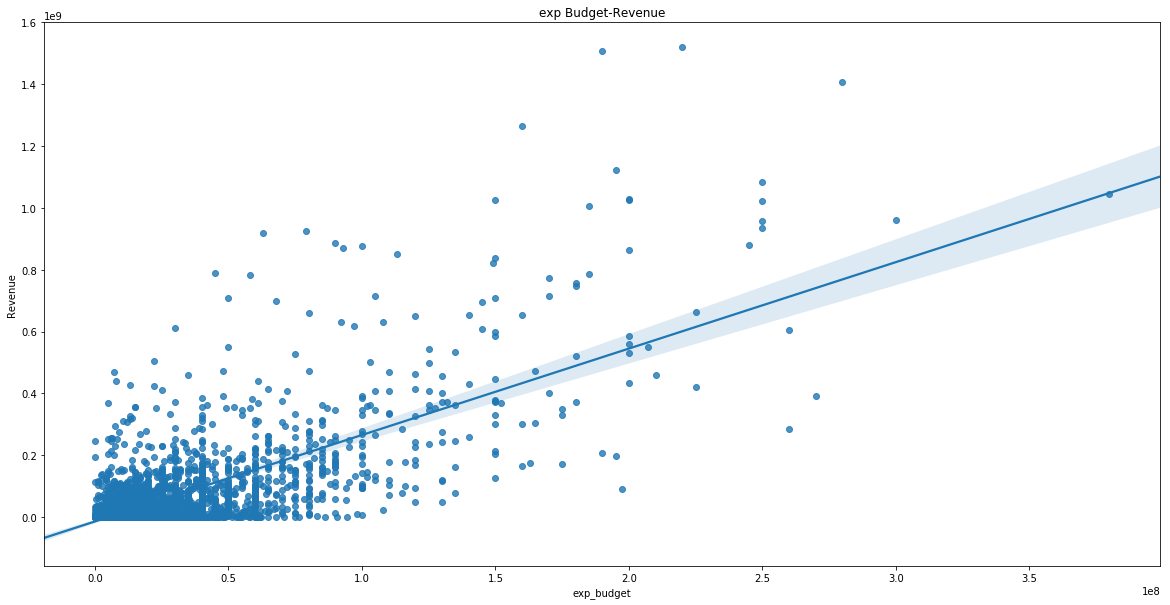

In [53]:
#train_runtime_posi=df_train_clean[df_train_clean['runtime']!=0]
fig,ax=plt.subplots(1,1) #row=2, col=2
fig.set_size_inches(20,10)
#plt.regplot(data=train_budget_posi, x='budget', y='revenue')
sns.regplot(x='exp_budget',y='revenue', data=df_train_clean, fit_reg=True)
plt.title("exp Budget-Revenue")
plt.xlabel('exp_budget')
plt.ylabel("Revenue")
plt.show()

# Remove unnecessary columns

In [54]:
drop_list=['homepage','poster_path','title','original_title','overview','tagline']

for name in drop_list:
    df_train_clean.drop(name,axis=1, inplace=True)

In [55]:
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 254 entries, id to exp_budget
dtypes: datetime64[ns](1), float64(3), int64(248), object(2)
memory usage: 5.8+ MB


In [56]:
status_map={"Released":1, "Rumored":0}

df_train_clean['status']=df_train_clean['status'].map(status_map)
df_test_clean['status']=df_test_clean['status'].map(status_map)

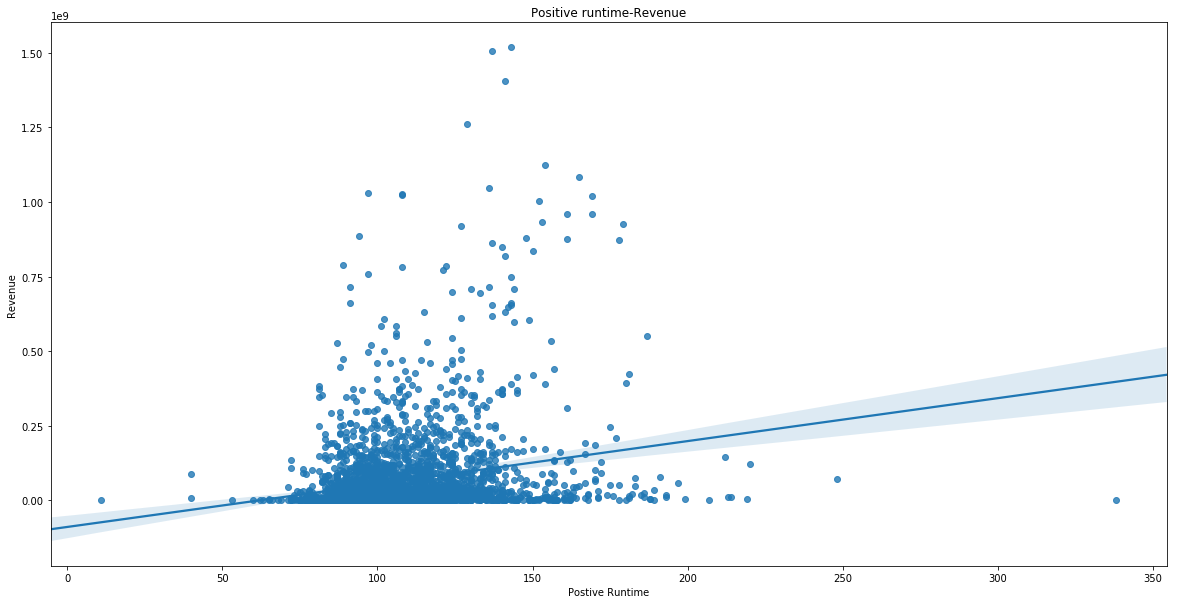

In [57]:
train_runtime_posi=df_train_clean[df_train_clean['runtime']!=0]
fig,ax=plt.subplots(1,1) #row=2, col=2
fig.set_size_inches(20,10)
#plt.regplot(data=train_budget_posi, x='budget', y='revenue')
sns.regplot(x='runtime',y='revenue', data=train_runtime_posi, fit_reg=True)
plt.title("Positive runtime-Revenue")
plt.xlabel('Postive Runtime')
plt.ylabel("Revenue")
plt.show()

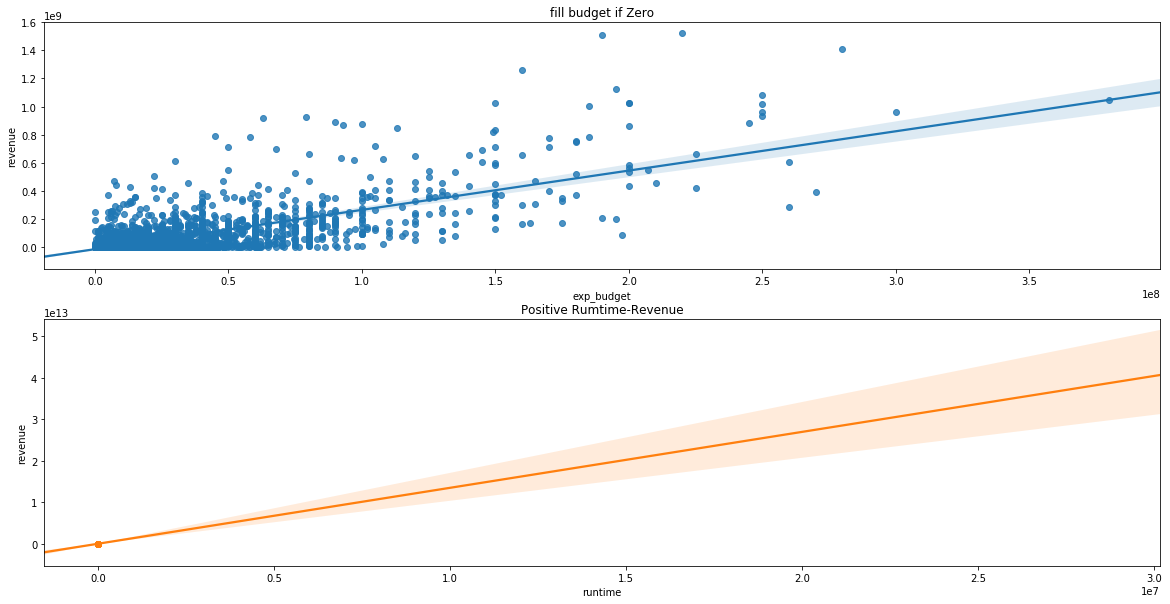

In [58]:
train_budget_posi=df_train_clean[df_train_clean['budget']!=0]
fig,ax=plt.subplots(2,1) #row=1, col=2
fig.set_size_inches(20,10)

sns.regplot(data=df_train_clean, x='exp_budget', y='revenue',fit_reg=True, ax=ax[0])
ax[0].set_title("fill budget if Zero")

##x1.title("Positive Budget-revenue")

sns.regplot(x='runtime',y='revenue', data=df_train_clean, fit_reg=True,ax=ax[1])
ax[1].set_title("Positive Rumtime-Revenue")
# plt.xlabel('Postive Budget')
# plt.ylabel("Revenue")
plt.margins()
plt.show()

In [59]:
df_train_clean.groupby('num_genres')['revenue'].mean()

num_genres
0    1.110844e+06
1    3.966845e+07
2    4.475659e+07
3    8.888497e+07
4    1.066105e+08
5    8.258928e+07
6    9.233659e+07
7    4.736216e+07
Name: revenue, dtype: float64

In [60]:
df_train_clean.sample(10)

,id,budget,imdb_id,original_language,popularity,release_date,runtime,status,revenue,has_collection,...,producer_Liza Chasin,producer_Tessa Ross,producer_Ben Waisbren,producer_Gary Barber,producer_Richard Brener,producer_John Lasseter,year,month,yr_mth,exp_budget
240,241,0,tt0118900,1,2.592927,1997-10-08,102.0,1,5790448,0,...,0,0,0,0,0,0,1997,10,199710,48822500.0
2306,2307,0,tt0860906,6,6.518028,2009-06-26,108.0,1,41162041,1,...,0,0,0,0,0,0,2009,6,200906,15330000.0
2598,2599,0,tt0083449,1,1.196669,1982-11-02,90.0,1,7241180,0,...,0,0,0,0,0,0,1982,11,198211,26846695.3
495,496,25000000,tt0119709,1,10.323838,1997-10-10,99.0,1,11838218,0,...,0,0,0,0,0,0,1997,10,199710,25000000.0
1742,1743,30000000,tt0119675,1,9.128905,1997-08-22,105.0,1,25480490,1,...,0,0,0,0,0,0,1997,8,199708,30000000.0
2591,2592,35000000,tt0124298,1,8.355977,1999-02-12,112.0,1,40263020,0,...,0,0,0,0,0,0,1999,2,199902,35000000.0
1261,1262,0,tt1964624,2,9.617662,2012-09-26,105.0,1,11879046,0,...,0,0,0,0,0,0,2012,9,201209,27974530.0
468,469,16000000,tt2103267,1,12.260159,2013-04-03,100.0,1,318982,0,...,0,0,0,0,0,0,2013,4,201304,16000000.0
1510,1511,68000000,tt0120053,1,10.976330,1997-04-03,116.0,1,118063304,1,...,0,0,0,0,0,0,1997,4,199704,68000000.0
2794,2795,8500000,tt1666801,1,8.592449,2015-02-20,100.0,1,43528634,0,...,0,0,0,0,0,0,2015,2,201502,8500000.0


In [61]:
df_test_clean[df_test_clean['budget']==0]

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,...,producer_Liza Chasin,producer_Tessa Ross,producer_Ben Waisbren,producer_Gary Barber,producer_Richard Brener,producer_John Lasseter,year,month,yr_mth,exp_budget
0,3001,0,http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,6.0,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,2007-07-14,...,0,0,0,0,0,0,2007,7,200707,80600000.0
2,3003,0,NaN,tt0118556,1.0,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,1997-05-23,...,0,0,0,0,0,0,1997,5,199705,19540000.0
5,3006,0,NaN,tt0120238,1.0,SubUrbia,A group of suburban teenagers try to support e...,8.679350,/7PdRbG09K9JHYyOwwCSn3OdJb0N.jpg,1996-02-07,...,0,0,0,0,0,0,1996,2,199602,18701500.0
6,3007,0,NaN,tt1517177,11.0,Drei,Hanna and Simon are in a 20 year marriage with...,4.898882,/cIIQJvsZePyYYjlQJMU3J0fcinu.jpg,2010-12-23,...,0,0,0,0,0,0,2010,12,201012,12900000.6
11,3012,0,NaN,tt3655522,2.0,Bande de filles,"Oppressed by her family setting, dead-end scho...",4.220318,/towsWW8B5U8wRXSI2RULoOFohP5.jpg,2014-06-27,...,0,0,0,0,0,0,2014,6,201406,8069145.9
15,3016,0,http://www.beautifulboythemovie.com/,tt1533013,1.0,Beautiful Boy,A married couple on the verge of separation ar...,2.114833,/dpntGfLK58eFZLTGgwqEfwnoWBq.jpg,2010-09-12,...,0,0,0,0,0,0,2010,9,201009,11880000.0
18,3019,0,NaN,tt0078754,1.0,All That Jazz,Bob Fosse's semi-autobiographical film celebra...,5.632325,/x4ppWRGH3pfVmEsbNC8UhvZVswd.jpg,1979-12-20,...,0,0,0,0,0,0,1979,12,197912,10482315.2
22,3023,0,NaN,tt0477392,1.0,Broken Bridges,A fading country music star (Keith) returns to...,1.120498,/nTrUwQByPhNlio1TlpEK18puzVS.jpg,2006-09-08,...,0,0,0,0,0,0,2006,9,200609,13150000.0
24,3025,0,NaN,tt1735907,1.0,The Adderall Diaries,Writer and Adderall enthusiast Stephen Elliott...,4.142280,/c4Ru5EJreB7WsnOJNHwedTt8lrk.jpg,2016-04-15,...,0,0,0,0,0,0,2016,4,201604,18816000.0
34,3035,0,NaN,tt2910274,1.0,Obvious Child,"An immature, newly unemployed comic must navig...",6.480574,/pPrL08T3aTATKKailk1IMSTK4gj.jpg,2014-06-06,...,0,0,0,0,0,0,2014,6,201406,6600000.0


In [62]:
x = df_train_clean.exp_budget.values.reshape(-1,1)
y = df_train_clean.revenue
reg = LinearRegression().fit(x, y)

In [63]:
predictions = reg.predict(df_test_clean['exp_budget'].values.reshape(-1,1))

In [64]:
submission['revenue'] = np.round(np.expm1(predictions))

C:\Users\B-17\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in expm1
  """Entry point for launching an IPython kernel.


In [65]:
submission.to_csv('submission_budget_linreg.csv', index = False)

In [66]:
i = 1
for column in list(df_train_clean.columns):
    print(str(i) + ' ' + column)
    i = i + 1

1 id
2 budget
3 imdb_id
4 original_language
5 popularity
6 release_date
7 runtime
8 status
9 revenue
10 has_collection
11 num_genres
12 num_production_companies
13 num_production_countries
14 num_spoken_languages
15 num_Keywords
16 num_cast
17 num_crew
18 belongs_to_collection_name_James Bond Collection
19 belongs_to_collection_name_Friday the 13th Collection
20 belongs_to_collection_name_The Pink Panther (Original) Collection
21 belongs_to_collection_name_Police Academy Collection
22 belongs_to_collection_name_Pokémon Collection
23 belongs_to_collection_name_Rocky Collection
24 belongs_to_collection_name_Ice Age Collection
25 belongs_to_collection_name_The Fast and the Furious Collection
26 belongs_to_collection_name_Rambo Collection
27 belongs_to_collection_name_Alien Collection
28 belongs_to_collection_name_Resident Evil Collection
29 belongs_to_collection_name_Child's Play Collection
30 belongs_to_collection_name_Transformers Collection
31 belongs_to_collection_name_Paranormal Acti

In [67]:
rf_cols = ['exp_budget', 'original_language', 'popularity',  'runtime', 'status', 'revenue','num_cast']
rf_train = df_train_clean[rf_cols].copy()
rf_cols.remove('revenue')
rf_test = df_test_clean[rf_cols].copy()

In [97]:
rf = RandomForestRegressor(n_jobs = -1)

In [84]:
rf_combined = pd.concat([rf_train, rf_test], sort=False)

In [85]:
def fill_runtime(df, median_runtime):
    df['runtime_is_median'] = 0
    df.loc[df.runtime == 0, 'runtime_is_median'] = 1
    df.loc[df.runtime.isnull() == True, 'runtime_is_median'] = 1
    df.loc[df.runtime == 0, 'runtime'] = median_runtime
    df.loc[df.runtime.isnull() == True, 'runtime'] = median_runtime
    return df

In [86]:
median_runtime = rf_train['runtime'].median()
median_runtime

104.0

In [87]:
rf_train = fill_runtime(rf_train, median_runtime)
rf_test = fill_runtime(rf_test, median_runtime)

In [88]:
rf_test['status'].fillna(1,inplace=True)

In [89]:
rf_test.isna().sum()

exp_budget           0
original_language    0
popularity           0
runtime              0
status               0
num_cast             0
runtime_is_median    0
dtype: int64

In [106]:
X_train, X_test, y_train, y_test = train_test_split(rf_train.drop('revenue', axis = 1), rf_train['revenue'], test_size=0.25, random_state=42)

In [107]:
y_train.isna().sum()

0

In [108]:
def rmse(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_pred, y_true))

In [109]:
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))
print(rmse(rf.predict(X_train), y_train))
print(rmse(rf.predict(X_test), y_test))

0.9157865812577799
0.5926907080889705
40635329.39037847
82712653.4680626


In [110]:
predictions = rf.predict(rf_test)

In [111]:
submission['revenue'] = np.round(np.expm1(predictions))

C:\Users\B-17\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in expm1
  """Entry point for launching an IPython kernel.


In [112]:
submission.head()

,id,revenue
0,3001,inf
1,3002,inf
2,3003,inf
3,3004,inf
4,3005,inf


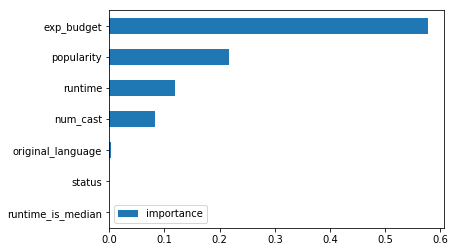

In [113]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=True)
feature_importances.plot(kind = 'barh')
plt.show()